In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv('./data.csv')
raw_data.head()

Time        V1        V2        V3        V4        V5        V6  \
0  127614.0  2.004188 -0.287498 -1.984934  0.342239  0.413188 -0.815346   
1  139389.0  2.346905 -1.264915 -1.034900 -1.568721 -1.122435 -0.790624   
2   68482.0 -3.089671  2.464689  0.042745  1.670674 -2.129076  0.600262   
3  123677.0  1.792358 -0.384458 -2.170063  0.096243  0.291162 -1.510182   
4  121222.0  2.188008 -0.400212 -1.627908 -0.225692 -0.133549 -1.273351   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.445456 -0.299258  0.562445  ... -0.038661 -0.127194  0.036464  0.504076   
1 -1.011732 -0.268243 -1.229191  ... -0.196288  0.015015  0.197023 -0.432445   
2 -1.627286  2.452801  0.319063  ... -0.223384 -0.441265  0.250283  0.091483   
3  0.921037 -0.525263 -0.088484  ...  0.297749  0.633531 -0.176001  0.146116   
4  0.226144 -0.553975 -0.908684  ... -0.338599 -0.220436  0.112804  0.049313   

        V25       V26       V27       V28  Amount  Class  
0  0.176423  0.541252 -0.121212 -0.064948   64.99      0  
1 -0.119139 -0.131627  0.015176 -0.058104    1.00      0  
2 -0.038373 -0.410096  0.088944  0.026973   30.70      0  
3  0.342753  0.198887 -0.117734 -0.061706  154.09      0  
4  0.157236  0.606729 -0.063450 -0.071105   10.00      0  

[5 rows x 31 columns]

## Setting aside testing and validation data
### Proportions: training - 70%, testing - 15%, validation - 15% 

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30)
splits1 = splitter1.split(raw_data, raw_data['Class'])

for train_id, test_id in splits1:
    data, test_and_valid_data = raw_data.iloc[train_id], raw_data.iloc[test_id]
    
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
splits2 = splitter2.split(test_and_valid_data, test_and_valid_data['Class'])

for test_id, valid_id in splits2:
    test_data, valid_data = test_and_valid_data.iloc[test_id], test_and_valid_data.iloc[valid_id]
    
data.shape, test_data.shape, valid_data.shape, sum(test_data['Class']), sum(valid_data['Class'])

((149523, 31), (32041, 31), (32041, 31), 55, 56)

## Data overview

In [4]:
splitter_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.05)
splits = splitter_2.split(data, data['Class'])

for _, ids in splits:
    small_data = data.iloc[ids]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

plt.figure(figsize=(17,3))
plt.gca().barh(['Not Fraud','Fraud'], [len(data)-sum(data['Class']), sum(data['Class'])])

plt.title('Number of fraudulent/trustworthy transactions', size=14);

In [6]:
sum(data['Class'])

258

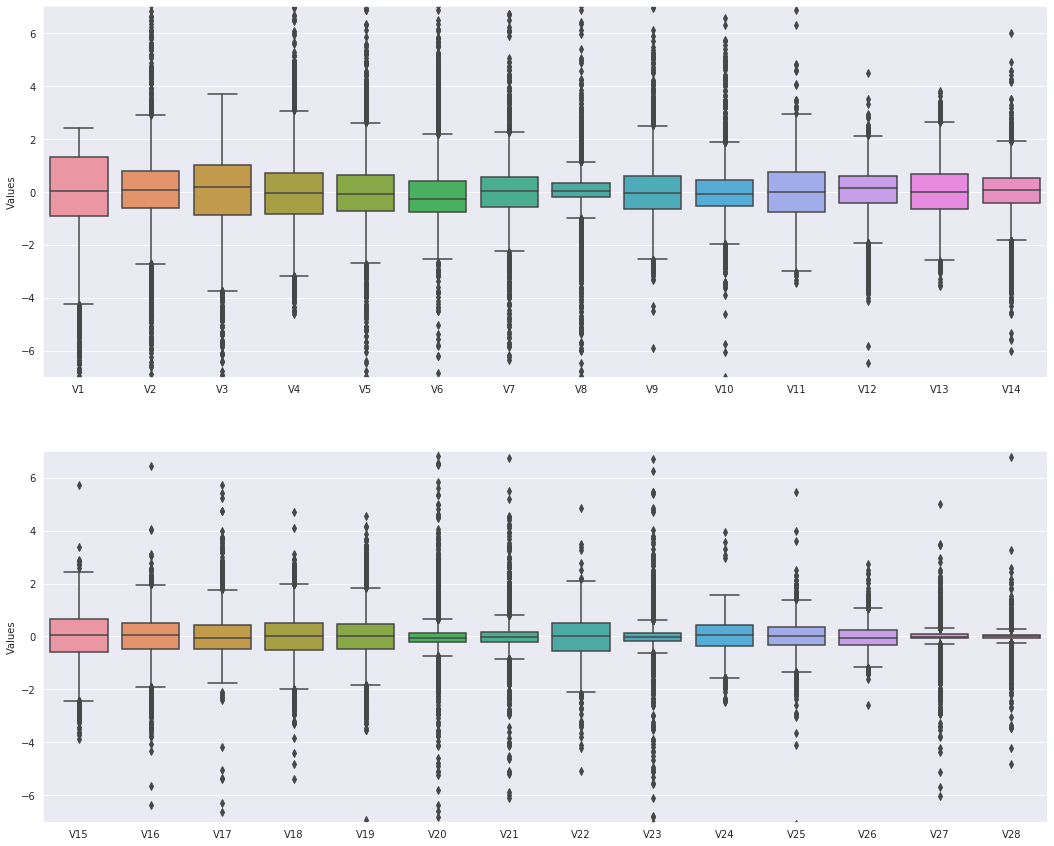

In [7]:
fig, ax = plt.subplots(nrows=2, figsize=(18, 15))
sns.boxplot(data=small_data.drop(['Time', 'Amount', 'Class'], axis=1).iloc[:,:14], ax=ax[0])
sns.boxplot(data=small_data.drop(['Time', 'Amount', 'Class'], axis=1).iloc[:,14:], ax=ax[1], )
ax[0].set_ylim([-7,7])
ax[0].set(ylabel='Values')
ax[1].set_ylim([-7,7])
ax[1].set(ylabel='Values');

/home/maciej/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


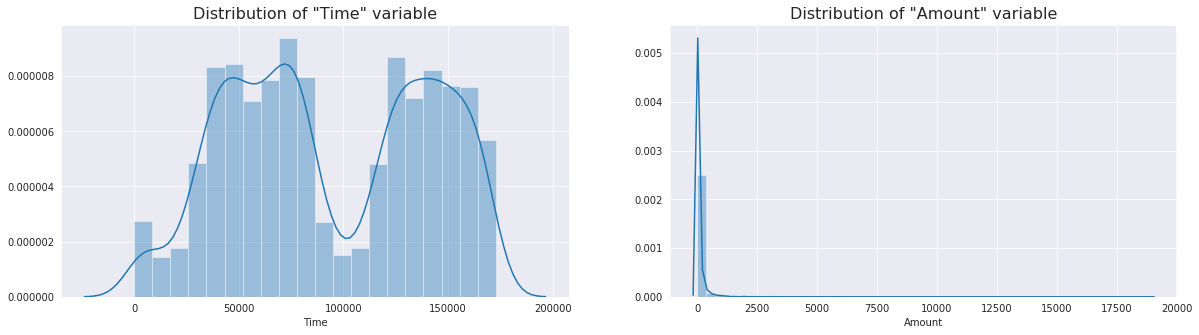

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
sns.distplot(small_data['Time'],  ax=ax[(0)])
sns.distplot(small_data['Amount'],  ax=ax[(1)])
ax[(0)].set_title('Distribution of "Time" variable', size=16)
ax[(1)].set_title('Distribution of "Amount" variable', size=16);

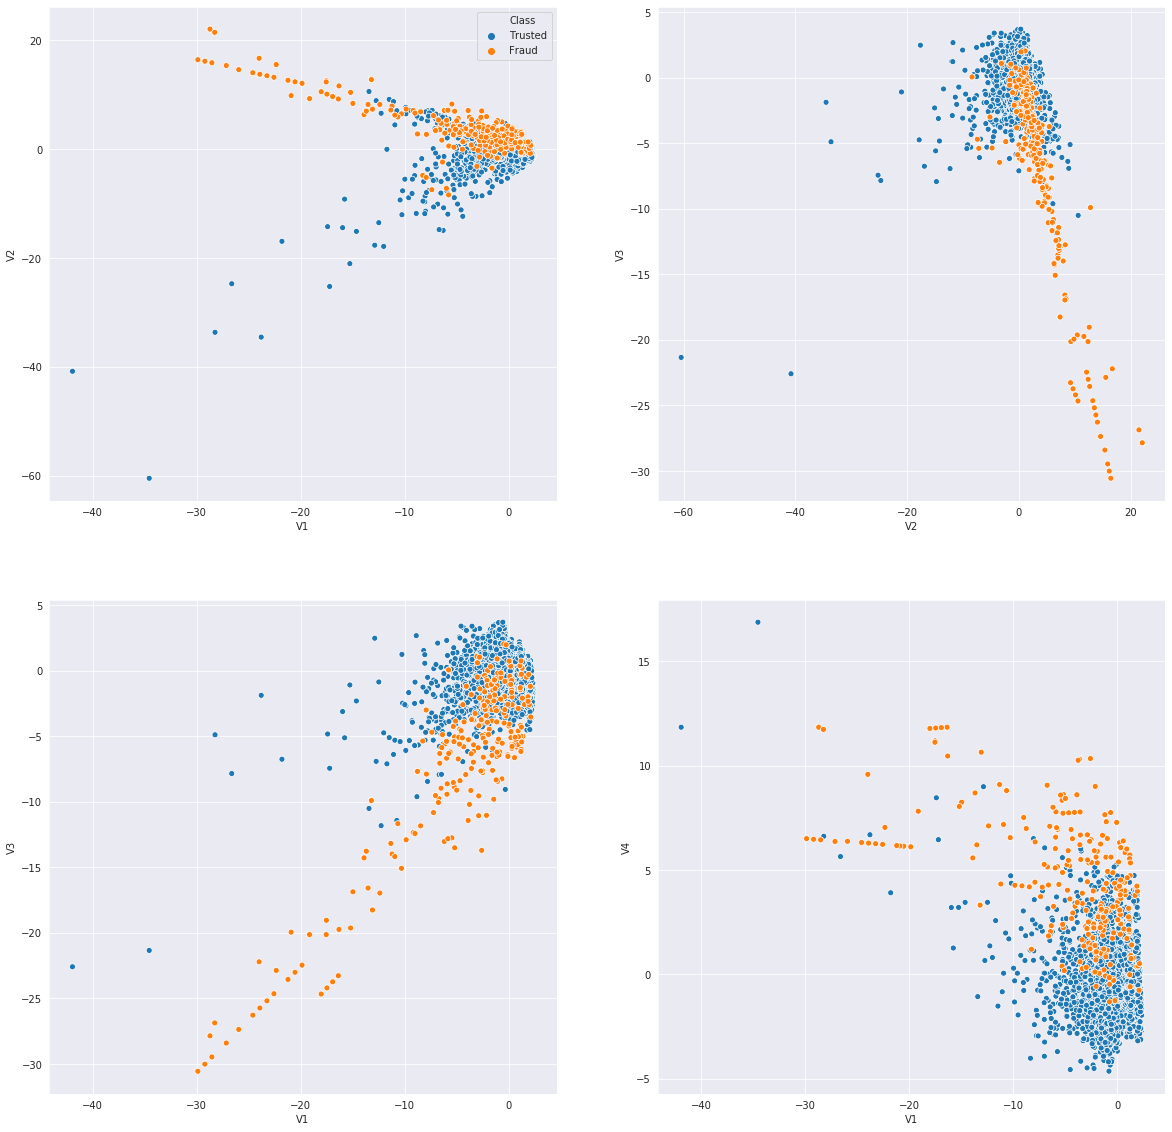

In [9]:
more_class_1 = small_data.append(data.loc[data['Class'] == 1])
more_class_1['Class'] = more_class_1['Class'].replace(1, 'Fraud')
more_class_1['Class'] = more_class_1['Class'].replace(0, 'Trusted')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
sns.scatterplot(x='V1', y='V2', hue='Class', data=more_class_1, ax=ax[0,0])
sns.scatterplot(x='V1', y='V3', hue='Class', data=more_class_1, ax=ax[1,0], legend=False)
sns.scatterplot(x='V2', y='V3', hue='Class', data=more_class_1, ax=ax[0,1], legend=False)
sns.scatterplot(x='V1', y='V4', hue='Class', data=more_class_1, ax=ax[1,1], legend=False)

In [10]:
import plotly.express as px
more_class_1['Amount'] = np.minimum(np.full(len(more_class_1), 10000),
                                more_class_1['Amount'].values)

fig = px.scatter_3d(more_class_1, x='V1', y='V2', z='V3',
              symbol='Class',color='Class', size=np.ones(len(more_class_1)), opacity=0.4, )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Preprocessing
### Scaling Time and Amount columns

In [11]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

scaler = RobustScaler()
time_amount_scaler = ColumnTransformer(
    [("norm1", scaler, [list(raw_data.columns).index('Time'),
                                list(raw_data.columns).index('Amount')] )],
    remainder='passthrough')
    
a = time_amount_scaler.get_params()['transformers'][0][1]

In [12]:
V_cols = [col for col in data.columns if col not in ['Time', 'Amount']]

data_scaled = time_amount_scaler.fit_transform(data)
data_scaled = pd.DataFrame(
    data_scaled,
    columns = ['Time', 'Amount'] + V_cols,
    index=data.index
)

valid_data_scaled = time_amount_scaler.transform(valid_data)
valid_data_scaled = pd.DataFrame(
    valid_data_scaled,
    columns = ['Time', 'Amount'] + V_cols,
    index=valid_data.index
)

all(valid_data['V1'] == valid_data_scaled['V1'])

True

## Feature selection

In [13]:
y = data['Class']
X = data_scaled.drop('Class', axis=1)

y_valid = valid_data['Class']
X_valid = valid_data_scaled.drop('Class', axis=1)

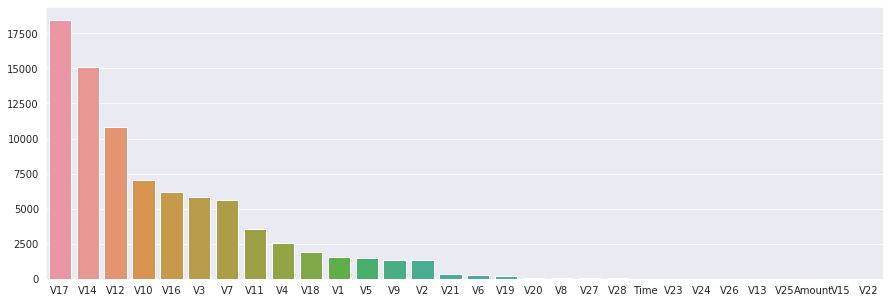

In [14]:
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(k=10)
feature_info = bestfeatures.fit(X, y)

fig, ax = plt.subplots(figsize=(15,5))
anova = pd.DataFrame(feature_info.scores_, index=X.columns).sort_values(by=0, ascending=False)
sns.barplot(x=anova.index, y=anova.values.reshape(-1), ax=ax);

### Undersampling
#### Algorithms: random undersampling, near-miss

In [15]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

undersampled_datasets = {
    'random_unders': RandomUnderSampler().fit_resample(X, y),
    'nearmiss_3': NearMiss(n_neighbors=3).fit_resample(X, y),
}

## Training
### Random undersampling

In [16]:
results = pd.DataFrame(
    columns=['model','params', 'sampling_type', 'n_features', 'valid_accuracy', 'valid_recall', 'valid_auc_score']
)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score

def results_row(searcher, model, sampling_type, top_index, valid_examples, valid_data):
    params = searcher.best_params_
    labels_pred = searcher.best_estimator_.predict(valid_examples)
    acc = accuracy_score(valid_labels, labels_pred)
    rec = recall_score(valid_labels, labels_pred)
    
    
    row = {'model': searcher.best_estimator_,
           'model_type': model,
         'params': searcher.best_params_,
         'sampling_type': sampling_type,
         'n_features': top_index,
         'valid_accuracy': acc,
         'valid_recall': rec,
         'valid_auc_score': roc_auc_score(valid_labels, searcher.best_estimator_.predict_proba(valid_examples)[:, 1])}
        
    return row

### Training AdaBoost with randomly undersampled dataset

In [18]:
from sklearn.ensemble import AdaBoostClassifier

X_unders, y_unders = undersampled_datasets['random_unders']

examples = X_unders
labels = y_unders

valid_examples = X_valid
valid_labels = y_valid

searcher = GridSearchCV(
    AdaBoostClassifier(),
    param_grid={'n_estimators': [35,40,45,50,55,60]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'AdaBoost', 'random', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.0s finished


### Training GradientBoost with randomly undersampled dataset


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

examples = X_unders
labels = y_unders

valid_examples = X_valid
valid_labels = y_valid


searcher = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid={'learning_rate': [0.85, 0.9, 0.95, 1, 1.05],
               'n_estimators': [90, 100, 110, 120, 130]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'GradientBoosting', 'random', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)



Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   20.3s finished


### Training RandomForestClassifer with randomly undersampled dataset


In [20]:
from sklearn.ensemble import RandomForestClassifier

examples = X_unders
labels = y_unders

valid_examples = X_valid
valid_labels = y_valid

searcher = GridSearchCV(
    RandomForestClassifier(),
    param_grid={'n_estimators': [80,100,120],
               'max_features': [2,3,5,7, 'auto'],
               'max_depth': [15,20,25, None],
               'bootstrap': [True]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'RandomForest', 'random', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   58.0s finished


In [21]:
from sklearn.svm import SVC

examples = bestfeatures.fit_transform(X_unders, y_unders)
labels = y_unders

valid_examples = bestfeatures.fit_transform(X_valid, y_valid)
valid_labels = y_valid

searcher = GridSearchCV(
    SVC(probability=True),
    param_grid={'C': [0.5, 0.7, 0.8, 0.90, 1],
               'kernel': ['linear', 'rbf', 'sigmoid'],
               'gamma': ['auto', 'scale'],
               'shrinking': [True, False]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'SVM', 'random', '6', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    6.3s finished


### Training KNN classifier with randomly undersampled dataset

In [22]:
from sklearn.neighbors import KNeighborsClassifier

examples = X_unders
labels = y_unders

valid_examples = X_valid
valid_labels = y_valid

searcher = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': [4,5,6,7,8,9],
               'weights': ['uniform', 'distance'],
               'algorithm': ['ball_tree', 'kd_tree', 'brute'],
               'p': [2,3,4]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'KNN', 'random', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   31.0s finished


### Training AdaBoost with nearmiss-undersampled dataset

In [23]:
X_nm, y_nm = undersampled_datasets['nearmiss_3']


examples = X_nm
labels = y_nm

valid_examples = X_valid
valid_labels = y_valid

searcher = GridSearchCV(
    AdaBoostClassifier(),
    param_grid={'n_estimators': [35,40,45,50,55,60]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher,'AdaBoosting', 'near_miss', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.0s finished


### Training GradientBoost with nearmiss-undersampled dataset

In [24]:
examples = X_nm
labels = y_nm

valid_examples = X_valid
valid_labels = y_valid

print(f'training on {anova.index[:14]} columns')

searcher = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid={'learning_rate': [0.9, 0.95, 1, 1.05, 1.1, 1.2],
               'n_estimators': [90, 100,105,110,115, 120]},
    verbose=1,
    scoring='roc_auc',
        )
searcher.fit(examples, labels)
row = results_row(searcher,'GradientBoosting', 'near_miss', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

training on Index(['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1',
       'V5', 'V9', 'V2'],
      dtype='object') columns
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   16.3s finished


### Training SVM on nearmiss-undersampled dataset

In [25]:
examples = bestfeatures.fit_transform(X_nm, y_nm)
labels = y_nm

valid_examples = bestfeatures.fit_transform(X_valid, y_valid)
valid_labels = y_valid

searcher = GridSearchCV(
    SVC(probability=True),
    param_grid={'C': [0.5, 0.7, 0.8, 0.90, 1],
               'kernel': ['linear', 'rbf', 'sigmoid'],
               'gamma': ['auto', 'scale'],
               'shrinking': [True, False]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'SVM', 'near_miss', '6', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.4s finished


### Training RandomForestClassifer on nearmiss-undersampled dataset

In [26]:
examples = X_nm
labels = y_nm

valid_examples = X_valid
valid_labels = y_valid

searcher = GridSearchCV(
    RandomForestClassifier(),
    param_grid={'n_estimators': [80,100,120,150],
               'max_features': [2,3,5,7, 'auto'],
               'max_depth': [15,20,25,30],
               'bootstrap': [True]},
    verbose=1,
    scoring='roc_auc'
        )
searcher.fit(examples, labels)
row = results_row(searcher, 'RandomForest', 'near_miss', 'all', valid_examples, valid_labels)
results = results.append(row, ignore_index=True)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.4min finished


# Results

In [27]:
results.sort_values('valid_auc_score')

model  \
7  SVC(C=1, break_ties=False, cache_size=200, cla...   
6  ([DecisionTreeRegressor(ccp_alpha=0.0, criteri...   
5  (DecisionTreeClassifier(ccp_alpha=0.0, class_w...   
8  (DecisionTreeClassifier(ccp_alpha=0.0, class_w...   
4  KNeighborsClassifier(algorithm='ball_tree', le...   
3  SVC(C=0.5, break_ties=False, cache_size=200, c...   
1  ([DecisionTreeRegressor(ccp_alpha=0.0, criteri...   
2  (DecisionTreeClassifier(ccp_alpha=0.0, class_w...   
0  (DecisionTreeClassifier(ccp_alpha=0.0, class_w...   

                                              params sampling_type n_features  \
7  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'sh...     near_miss          6   
6       {'learning_rate': 0.95, 'n_estimators': 105}     near_miss        all   
5                               {'n_estimators': 60}     near_miss        all   
8  {'bootstrap': True, 'max_depth': 15, 'max_feat...     near_miss        all   
4  {'algorithm': 'ball_tree', 'n_neighbors': 4, '...        random        all   
3  {'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'...        random          6   
1       {'learning_rate': 0.95, 'n_estimators': 120}        random        all   
2  {'bootstrap': True, 'max_depth': 20, 'max_feat...        random        all   
0                               {'n_estimators': 35}        random        all   

   valid_accuracy  valid_recall  valid_auc_score        model_type  
7        0.048438      1.000000         0.621635               SVM  
6        0.198184      0.910714         0.758519  GradientBoosting  
5        0.235011      0.928571         0.801922       AdaBoosting  
8        0.043007      0.946429         0.825800      RandomForest  
4        0.956181      0.875000         0.939175               KNN  
3        0.972067      0.803571         0.946120               SVM  
1        0.945039      0.875000         0.964803  GradientBoosting  
2        0.974501      0.839286         0.971135      RandomForest  
0        0.956993      0.892857         0.983067          AdaBoost

In [28]:
best_model, name, params = results.sort_values('valid_auc_score', ascending=False).iloc[0, [0, 7, 1]]
name, params

('AdaBoost', {'n_estimators': 35})

Final results: Acc:0.9905433663119129, Rec: 0.8363636363636363, (for treshhold = 0.7)
Auc score: 0.9733460093336289


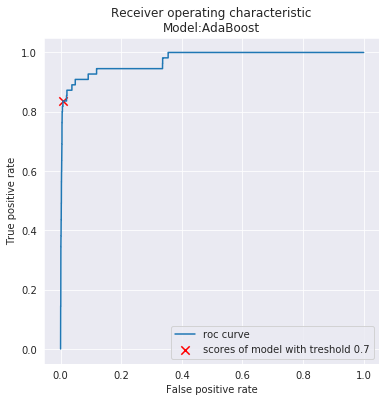

In [32]:
test_data_scaled = time_amount_scaler.transform(test_data)
test_data_scaled = pd.DataFrame(
    test_data_scaled,
    columns = ['Time', 'Amount'] + V_cols,
    index = test_data.index
)

test_labels = test_data_scaled['Class']
test_examples = test_data_scaled.drop('Class', axis=1)

treshold = 0.7
acc = accuracy_score(test_labels, best_model.predict_proba(test_examples)[:, 1]>treshold)
rec = recall_score(test_labels, best_model.predict_proba(test_examples)[:, 1] > treshold)
print(f'Final results: Acc:{acc}, Rec: {rec}, (for treshhold = {treshold})')
print(f'Auc score: {roc_auc_score(test_labels, best_model.predict_proba(test_examples)[:, 1])}')

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
lr_fpr, lr_tpr, _ = roc_curve(test_labels, best_model.predict_proba(test_examples)[:, 1])
ax.plot(lr_fpr, lr_tpr, label='roc curve')
plt.title(f'Receiver operating characteristic\nModel:{name}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.scatter(1-acc, rec, marker='x', c='red', s=70, label=f'scores of model with treshold {treshold}')
plt.legend()
plt.show()

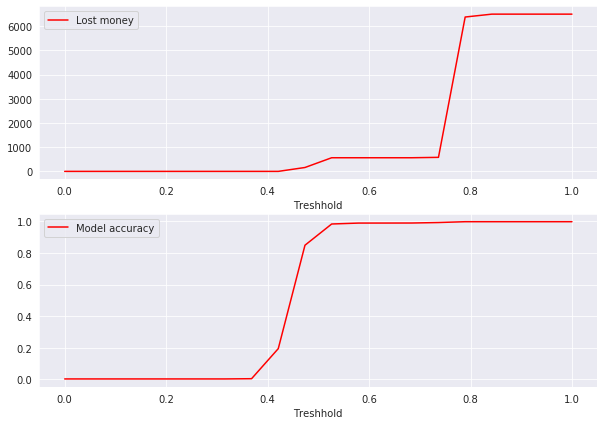

In [33]:
def lost_money(t):
    return np.sum(
        ((best_model.predict_proba(test_examples)[:, 1]>t) != test_labels.values) * test_labels.values * test_data['Amount']
    )
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,7))
T = np.linspace(0,1,20)
ax1.plot(T, [lost_money(t) for t in T], c='red', label='Lost money')
ax1.set_xlabel('Treshhold')
ax2.plot(T, [accuracy_score(test_labels, best_model.predict_proba(test_examples)[:, 1]>t) for t in T], c='red', label='Model accuracy')
ax2.set_xlabel('Treshhold')
ax1.legend()
ax2.legend()